In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_train = zipfile.ZipFile('/content/drive/MyDrive/PlantVillage.zip', 'r') #Opens the zip file in read mode
zip_train.extractall('/tmp') #Extracts the files into the /tmp folder
zip_train.close()

In [ ]:
# copy try
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.models import Model

In [ ]:
IMAGE_SIZE=224
BATCH_SIZE=32
CHANNELS =3
EPOCHS=5

In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/tmp/PlantVillage",
    shuffle=True,
    image_size =(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

68

In [ ]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 224, 224, 3)
[1 0 1 0 2 1 0 0 2 1 0 1 0 0 0 0 1 0 1 1 2 1 1 0 2 1 2 0 2 0 0 0]


In [ ]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:

train_size=0.8
len(dataset)*train_size

54.400000000000006

In [ ]:
train_ds =dataset.take(54)
test_ds =dataset.skip(54)

In [ ]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [ ]:

val_ds = test_ds.take(6)
len(val_ds)


6

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [ ]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds=ds.take(train_size)

    val_ds=ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds,test_ds,val_ds

In [ ]:
train_ds,test_ds,val_ds=get_dataset_partitions_tf(dataset)

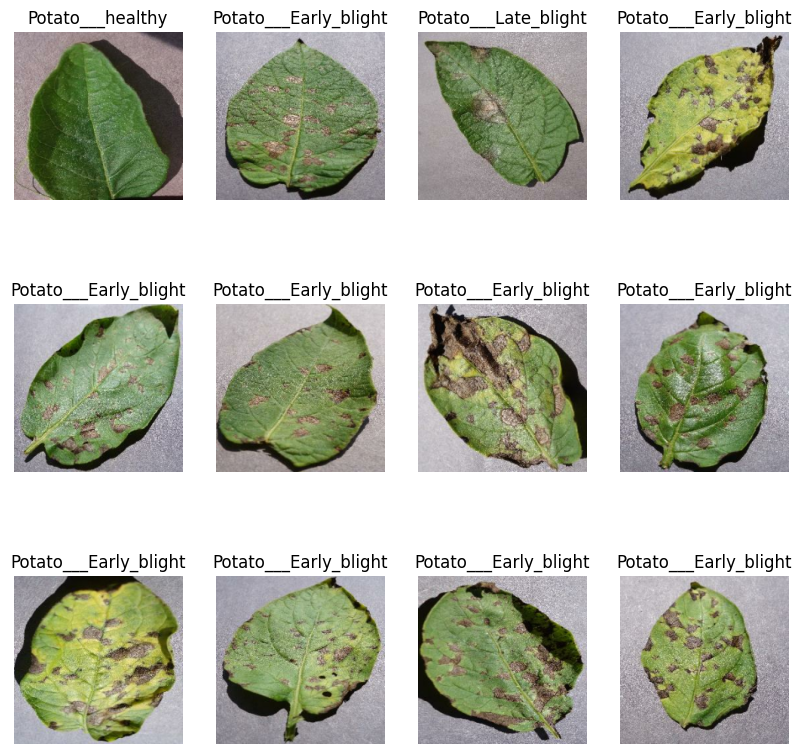

In [ ]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in test_ds.take(1):
    for i in range(12):
        ax =plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis("off")

In [ ]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
IMAGE_SHAPE=(224,224)
CHANNELSS=3

In [ ]:
base_vgg16=VGG16(weights="imagenet", include_top =False,input_shape=(IMAGE_SHAPE[0],IMAGE_SHAPE[1],CHANNELSS))
base_vgg16.trainable= False

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
gabor_input_shape = (224, 224, 3)
class GaborFilterLayer(layers.Layer):
    def __init__(self, num_filters, kernel_size, strides=(1, 1), padding='SAME', activation='relu'):
        super(GaborFilterLayer, self).__init__()
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.activation = tf.keras.activations.get(activation)
        self.gabor_filters = self.build_gabor_filters()

    def build_gabor_filters(self):
        filters = []
        for _ in range(self.num_filters):
            filter_initializer = tf.keras.initializers.RandomNormal(mean=0.5, stddev=0.1)
            filter = self.add_weight(shape=(self.kernel_size[0], self.kernel_size[1], 3, 1),
                                     initializer=filter_initializer,
                                     trainable=False)
            filters.append(filter)
        return filters

    def call(self, inputs):
        outputs = []
        for filter in self.gabor_filters:
            conv_output = tf.nn.conv2d(inputs, filter, strides=self.strides, padding=self.padding)
            outputs.append(conv_output)
        return self.activation(tf.concat(outputs, axis=-1))

In [ ]:
# input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes =3
gabor_input_shape = (224, 224, 3)  # VGG16 input shape


model=models.Sequential([
    layers.Input(shape=gabor_input_shape),
    resize_and_rescale,
    data_augmentation,
    GaborFilterLayer(num_filters=16, kernel_size=(5, 5)),
    layers.Conv2D(3, kernel_size=(1, 1), activation='relu'),
#     layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    base_vgg16,
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Flatten(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']
             )

In [ ]:
history=model.fit(train_ds,
          epochs=50,
          batch_size=BATCH_SIZE,
          verbose=1,
          validation_data=val_ds
         )

Epoch 1/50
54/54 [==============================] - 48s 452ms/step - loss: 0.5504 - accuracy: 0.7694 - val_loss: 0.3234 - val_accuracy: 0.9010
Epoch 2/50
54/54 [==============================] - 18s 342ms/step - loss: 0.3152 - accuracy: 0.8832 - val_loss: 0.2884 - val_accuracy: 0.9010
Epoch 3/50
54/54 [==============================] - 18s 342ms/step - loss: 0.2638 - accuracy: 0.9085 - val_loss: 0.2201 - val_accuracy: 0.9167
Epoch 4/50
54/54 [==============================] - 17s 321ms/step - loss: 0.2309 - accuracy: 0.9143 - val_loss: 0.2025 - val_accuracy: 0.9271
Epoch 5/50
54/54 [==============================] - 18s 326ms/step - loss: 0.2427 - accuracy: 0.9067 - val_loss: 0.2543 - val_accuracy: 0.8958
Epoch 6/50
54/54 [==============================] - 19s 344ms/step - loss: 0.2368 - accuracy: 0.9085 - val_loss: 0.1872 - val_accuracy: 0.9323
Epoch 7/50
54/54 [==============================] - 18s 330ms/step - loss: 0.2127 - accuracy: 0.9278 - val_loss: 0.1825 - val_accuracy: 0.9323

In [ ]:
model.evaluate(test_ds)

8/8 [==============================] - 4s 155ms/step - loss: 0.0964 - accuracy: 0.9727


[0.09640077501535416, 0.97265625]

In [ ]:
Predicted=model.predict(test_ds.take(1))

1/1 [==============================] - 0s 274ms/step


In [ ]:
Predicted[1]

array([5.3333456e-04, 5.5392772e-01, 4.4553891e-01], dtype=float32)

In [ ]:
import numpy as np
np.argmax(Predicted[5],axis=-1)

2

In [ ]:
for A,B in test_ds:
  # print(A)
  print(B)

tf.Tensor([0 1 1 1 0 2 1 0 1 1 0 1 1 0 0 2 0 0 2 1 2 0 1 0 1 1 0 0 1 1 1 1], shape=(32,), dtype=int32)
tf.Tensor([2 1 0 2 0 1 1 1 1 1 1 0 0 0 2 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0], shape=(32,), dtype=int32)
tf.Tensor([1 1 2 0 1 1 0 0 1 1 0 0 2 0 0 1 1 1 1 0 2 0 0 1 1 1 0 2 0 1 1 0], shape=(32,), dtype=int32)
tf.Tensor([1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 2 1 0 0 0 1 1 0 1 1 1 0 0 1 0], shape=(32,), dtype=int32)
tf.Tensor([1 1 0 1 0 0 1 1 2 0 1 0 0 0 1 1 1 1 0 1 0 0 1 0 2 0 0 1 0 0 0 0], shape=(32,), dtype=int32)
tf.Tensor([0 1 1 1 1 0 2 1 0 0 0 2 0 0 0 1 0 0 2 1 0 1 0 0 1 1 1 2 1 1 0 0], shape=(32,), dtype=int32)
tf.Tensor([2 1 1 0 2 1 0 2 1 2 1 1 0 0 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0], shape=(32,), dtype=int32)
tf.Tensor([1 1 1 0 1 0 2 1 2 0 2 1 1 1 1 1 1 1 0 0 0 0 1 1 0 2 2 0 1 1 1 0], shape=(32,), dtype=int32)


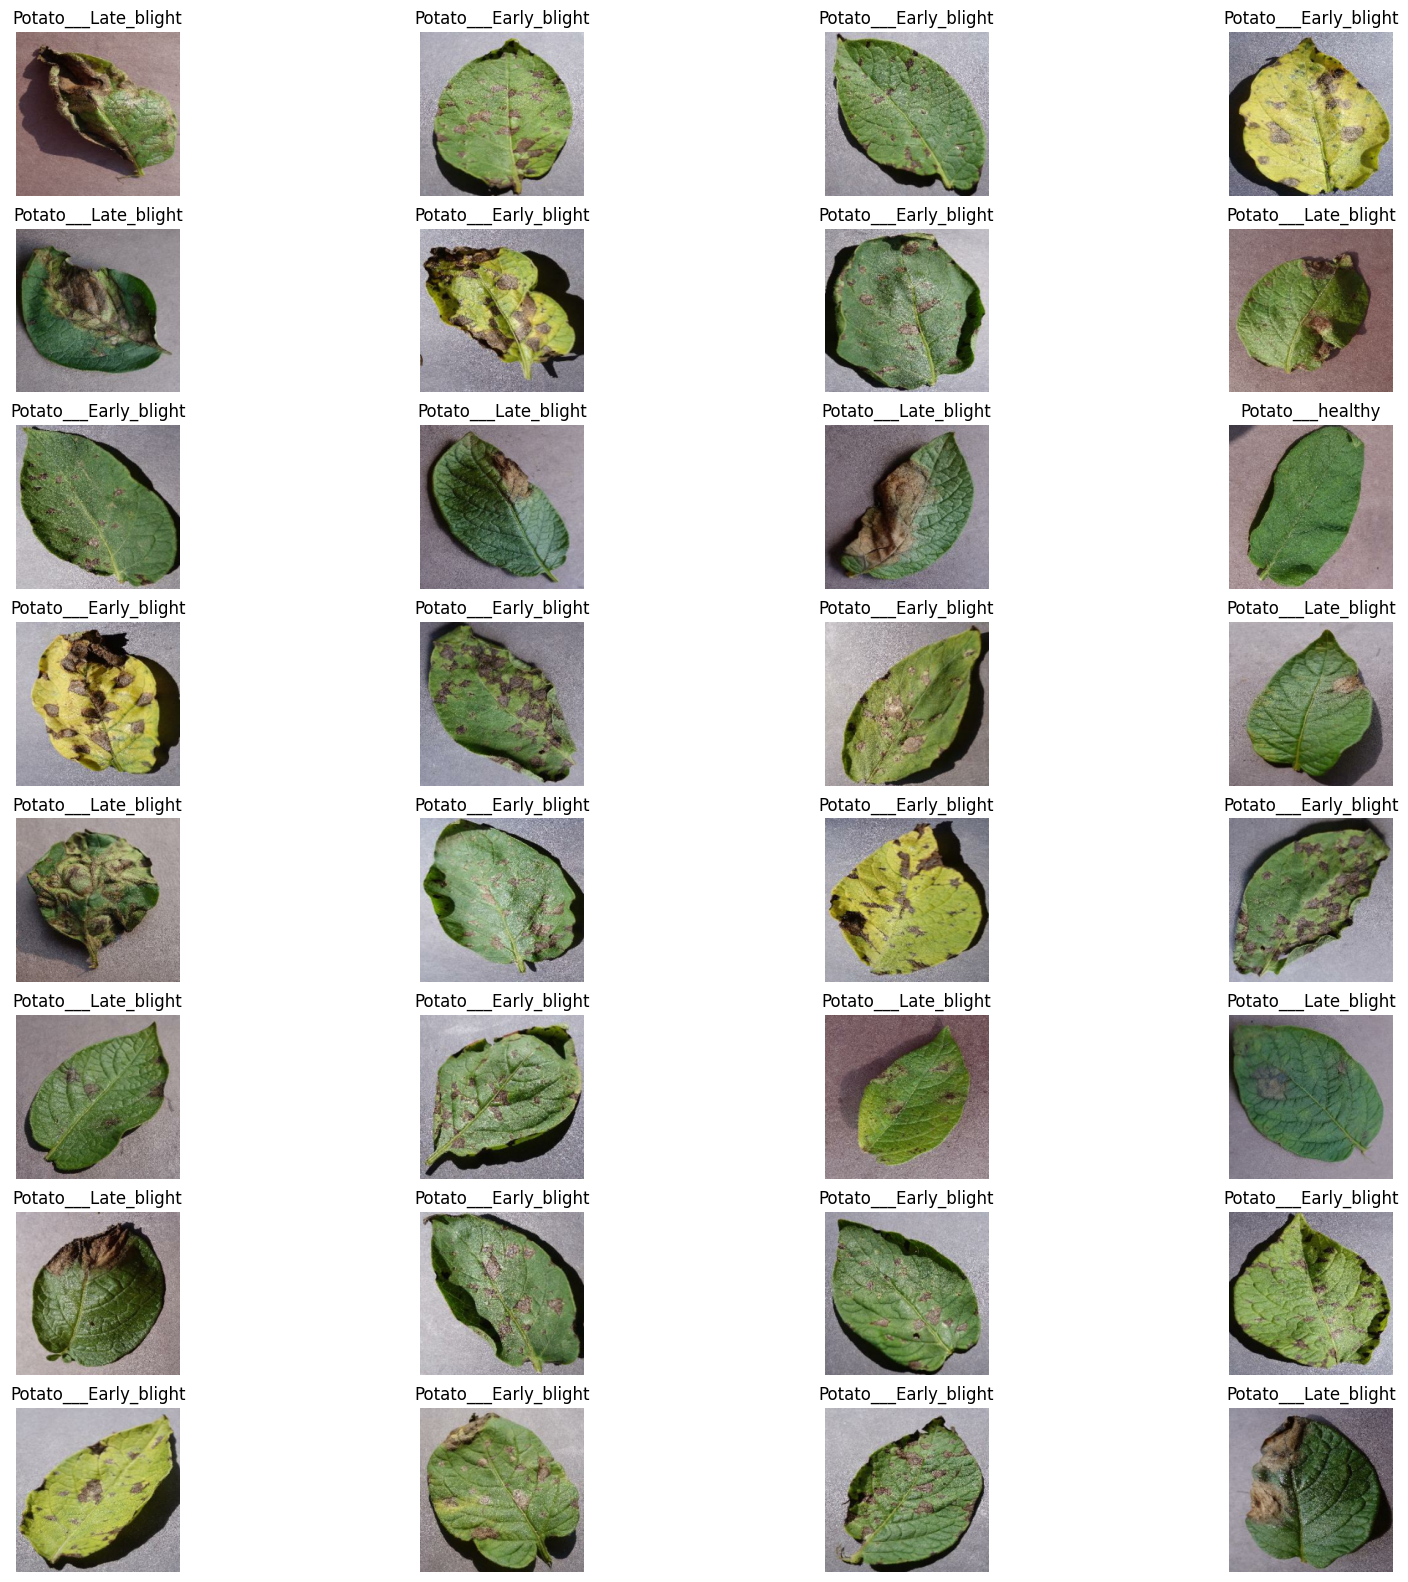

In [ ]:
plt.figure(figsize=(20,20))
for image_batch,label_batch in test_ds:
    for i in range(32):
        ax =plt.subplot(4,8,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis("off")

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [ ]:
# model.save('/content/drive/MyDrive/model/Class33.hdf5')

ValueError: ignored

In [ ]:

# from tensorflow.keras.models import save_model

ImportError: ignored

In [ ]:
# Load the trained model
# model = tf.keras.models.load_model("/content/drive/MyDrive/model/Class33.hdf5")

# # Load and preprocess the external image
# external_image_path = "https://www.google.com/imgres?imgurl=https%3A%2F%2Fwww.apsnet.org%2Fedcenter%2Fdisandpath%2Foomycete%2Fpdlessons%2FPublishingImages%2FLateBlightFig3new.jpg&tbnid=qmk-r_-qgjboWM&vet=12ahUKEwjzjeO7xe2AAxVypycCHU-UBV8QMygEegQIARBQ..i&imgrefurl=https%3A%2F%2Fwww.apsnet.org%2Fedcenter%2Fdisandpath%2Foomycete%2Fpdlessons%2FPages%2FLateBlight.aspx&docid=A-HN5yic_IobEM&w=267&h=200&q=Potato___Late_blight&ved=2ahUKEwjzjeO7xe2AAxVypycCHU-UBV8QMygEegQIARBQ"
# external_image = load_img(external_image_path, target_size=IMAGE_SIZE)
# external_image_array = img_to_array(external_image)
# external_image_array = external_image_array / 255.0
# external_image_array = external_image_array.reshape(1, *external_image_array.shape)

# # Make predictions
# predictions = model.predict(external_image_array)
# class_index = tf.argmax(predictions[0]).numpy()
# predicted_class = class_name[class_index]

# # Display results
# print("Predicted class:", predicted_class)
# print("Predicted probabilities:", predictions[0])


ValueError: ignored

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import save_model

# # ... (define and train your model)

# # Save the model
# save_model(model, "/content/drive/MyDrive/model/my_model.h5")


ValueError: ignored

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import load_model
# from your_custom_module import GaborFilterLayer  # Import the custom layer class

# # Load the model with custom layer
# with tf.keras.utils.custom_object_scope({'GaborFilterLayer': GaborFilterLayer}):
#     loaded_model = load_model("/content/drive/MyDrive/model/my_model.h5",custom_objects={'GaborFilterLayer': GaborFilterLayer})


ModuleNotFoundError: ignored